In [1]:
############********** Project1 Task2 Training File **********############


import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.datasets import make_classification
from sklearn_pandas import CategoricalImputer
#from feature_engine.imputation import CategoricalImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
import datetime as dt

from datetime import date
import holidays

pd.set_option("display.max_columns", None)


In [72]:
###--- Connecting to the server to access the database ---###

#conn = pyodbc.connect('Driver={SQL Server};'
#'Server=HCV171DTMBPDA01\DTMBSQL16PRD.NGDS.state.mi.us,1910;'
#'Database=DTMB_CentralProcurement;'
#'Trusted_Connection=yes;')

#cursor = conn.cursor()

In [4]:
###--- Retrieving tables from the database using queries ---###

#query_1 = "SELECT * FROM tblProjects WHERE ProjectType = 'RFP' Or ProjectType\
#= 'C-RFP' Or ProjectType = 'CN' Or ProjectType = 'DS' Or ProjectType = 'CO-OP'Or ProjectType = 'ITN'Or ProjectType = 'CPC' Or ProjectType = 'RFS'"
#query_2 = "SELECT * FROM tblContractCategories"


#df_projects = pd.read_sql_query(query_1, conn)
#df_projects = df_projects[df_projects['CategoryID'].notna()]
#df_projects = df_projects.astype({'CategoryID': 'int64'})

#df_level = pd.read_sql_query(query_2, conn)
#df_level = df_level[['LevelCalc', 'CategoryID']]

#df = df_projects.join(df_level.set_index('CategoryID'), on='CategoryID')
#df = df[(df["ProjectStage"] == 'Complete')]
#df.shape

In [3]:
###--- accessing the data from the spreadsheets instead of the server ---###

df_projects = pd.read_csv('projects.csv')
df_projects = df_projects.drop('Unnamed: 0',axis=1)
df_level = pd.read_csv('levels_and_scores.csv')
df_level = df_level.drop('Unnamed: 0',axis=1)


In [78]:
###--- Data pre-processing and cleaning for training model---###

def prepare_df2(df):
    
    #Calculating the duration
    df = df.reset_index()
    df = df.dropna(subset=['PlanFinishDate'])
    mi_holidays = holidays.UnitedStates(state='MI')
    start = df['PlanStartDate'].astype(str)
    end = df['ActualFinishDate'].astype(str)
    bus = []
    holi = []
    dur = []
    start_list = start.tolist()
    end_list = end.tolist()
    for i in range(len(start_list)):
        holi.append(len(mi_holidays[start_list[i]: end_list[i]]))
        bus.append(np.busday_count(start_list[i], end_list[i]))

    zip_object = zip(bus, holi)
    for list1_i, list2_i in zip_object:
        dur.append(list1_i-list2_i)
    df['dur'] = dur
    variables_to_remove = ['index','SharePointID', 'ID', 'ProjectName', 'CreateDate', 'PlanStartDate',
             'PlanFinishDate', 'StatusDate', 'ProjectDescription', 'Status', 'StatusDate', 'ProjectDescription',
             'Status', 'RefrenceNumber', 'ProjectStage', 'CancelationReason', 'ActualFinishDate', 'Unit',
             'SolicitationStatus', 'LastUpdatedBy', 'LastUpdateDate', 'LastUpdatedField', 'SolicitationNum',
             'SensitivityIndicator', 'SourcingCategory', 'DollarAmount']

    df = df.drop(variables_to_remove, axis = 1)
    df = df.rename(columns={"dur": "Duration"})
    df = df[df["Duration"]>0]
    # handling NaN values
    imputer = CategoricalImputer()
    data = np.array(df['Planned'], dtype=object)
    data2 = np.array(df['CreatedBy'], dtype=object)
    data3 = np.array(df['BuyerName'], dtype=object)

    df['Planned'] = imputer.fit_transform(data)
    df['CreatedBy'] = imputer.fit_transform(data2)
    df['BuyerName'] = imputer.fit_transform(data3)
    df = df.dropna()
    df = df.reset_index()
    df = df.drop('index', axis = 1)
    return df

def met_sla(df):
    
    if df['Duration'] <= df['SLA']:
        val = 1
    elif df['Duration'] > df['SLA']:
        val = 0
    return val

model2_df = prepare_df2(df)
model2_df['Met_SLA'] = model2_df.apply(met_sla, axis=1)
model2_df.head()

,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Duration,Met_SLA
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,5,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,54,1
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,58,1
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,101,1
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,172,0


In [ ]:
#durarr = model2_df["Duration"].to_numpy() 
#durcat = (pd.cut(durarr,
#       9, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])).tolist()

#model2_df['DurationCat'] = durcat

#model2_df.head()

In [35]:
bin_labels  = ['0','0 to 50 Days', '51 to 100 Days','101 to 150 Days','151 to 200 Days','201 to 250 Days','251 to 300 Days',\
               '301 to 350 Days','>400']

bins = [0,50,100,150,200,250,300,350,400,2000]

#model2_df['quantile_ex_3'] = pd.qcut(model2_df['Duration'],
 #                             q=bins,
#                              labels=bin_labels)

model2_df['bins'] = pd.cut(model2_df['Duration'], bins=bins, labels=bin_labels, include_lowest=True)

In [79]:
model2_df

,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Duration,Met_SLA
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,5,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,54,1
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,58,1
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,101,1
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3324,Green,CN,lugibihlc,231,VAH,4.0,PROF,50,No,75,False,False,2,7,1
3325,Green,CN,lugibihlc,271,SW2,4.0,PROF,50,No,273,False,False,4,4,1
3326,Green,CN,lugibihlc,591,SW2,1.0,PROF,50,No,4,False,False,4,3,1
3327,Green,CN,lugibihlc,171,SW2,2.0,PROF,50,No,4,False,False,4,1,1


In [80]:
#putting duration ranges into categories

duration = []
for item in model2_df['Duration'].to_list():
    if abs(int(item)) >=0 and abs(int(item)) < 50:
        duration.append(1)
    elif abs(int(item)) >=50 and abs(int(item)) < 100:
        duration.append(2)
    elif abs(int(item)) >=100 and abs(int(item)) < 150:
        duration.append(3)
    elif abs(int(item)) >=150 and abs(int(item)) < 200:
        duration.append(4)
    elif abs(int(item)) >=200 and abs(int(item)) < 250:
        duration.append(5)
    elif abs(int(item)) >=250 and abs(int(item)) < 300:
        duration.append(6)
    elif abs(int(item)) >=300 and abs(int(item)) < 350:
        duration.append(7)
    elif abs(int(item)) >=350 and abs(int(item)) < 400:
        duration.append(8)
    elif abs(int(item)) >=400:
        duration.append(9)

#creating duration category column
model2_df['DurationCat'] = duration
model2_df = model2_df.drop(['Duration'], axis = 1)

print(model2_df.shape)
model2_df.head()


(3329, 15)


,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Met_SLA,DurationCat
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,1,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,1,2
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,1,2
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,1,3
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,0,4


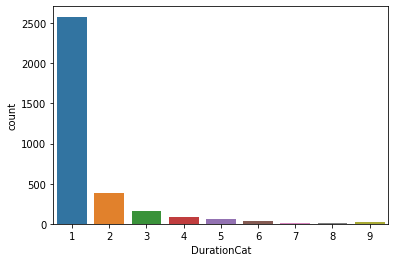

In [81]:
#bar plot for project completion periods categories
#sns.set_theme(style="darkgrid")
sns.countplot(model2_df['DurationCat'],label="Count")


In [82]:
#declare the feature set and the target set
X = model2_df[['ProjectColor', 'ProjectType', 'CreatedBy',  'WorkPerformedFor', 'BuyerName', 'Hours', 'Division', 'SLA', 'Planned',
         'CategoryID', 'FedReview', 'ITComponent', 'LevelCalc', 'Met_SLA']]
y = model2_df['DurationCat']


In [83]:
###--- Functions that prepares data for model--> turns data entries to a form the model can read ---###

def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value= 569)
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

X = model2_df.iloc[:, :-1]
y = model2_df.iloc[:,-1]
    # format all fields as string
X = X.astype(str)
np.set_printoptions(threshold=sys.maxsize)
X


,ProjectColor,ProjectType,CreatedBy,WorkPerformedFor,BuyerName,Hours,Division,SLA,Planned,CategoryID,FedReview,ITComponent,LevelCalc,Met_SLA
0,Green,CN,keilenn,071,JY1,0.0,PROF,63,Yes,50,False,False,3,1
1,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,Yes,185,False,False,2,1
2,Green,RFP,Gibrilm,000,YMD,120.0,COMM,138,No,184,False,False,3,1
3,Green,RFP,Gibrilm,591,YMD,120.0,COMM,138,No,301,False,False,2,1
4,Green,RFP,Gibrilm,431,SR4,120.0,COMM,138,No,143,False,False,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3324,Green,CN,lugibihlc,231,VAH,4.0,PROF,50,No,75,False,False,2,1
3325,Green,CN,lugibihlc,271,SW2,4.0,PROF,50,No,273,False,False,4,1
3326,Green,CN,lugibihlc,591,SW2,1.0,PROF,50,No,4,False,False,4,1
3327,Green,CN,lugibihlc,171,SW2,2.0,PROF,50,No,4,False,False,4,1


In [87]:
###--- Running algorithm that selects the best features ---###


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

unique_elements, counts_elements = np.unique(y_train_enc, return_counts=True)


Feature 0: 101.773346
Feature 1: 946.066358
Feature 2: 171.691760
Feature 3: 80.949199
Feature 4: 187.665504
Feature 5: 1813.229442
Feature 6: 8.180635
Feature 7: 150.777207
Feature 8: 69.570430
Feature 9: 168.783925
Feature 10: 19.024040
Feature 11: 41.559406
Feature 12: 6.165381
Feature 13: 259.825443


In [88]:
X_train_enc = np.delete(X_train_enc, np.s_[6, 12], 1)
X_test_enc = np.delete(X_test_enc, np.s_[6, 12], 1)

In [90]:
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

#run algorithm multiple times to get desired accuracy
desired_accu = 0
while desired_accu < 0.869:

    
    #oversample training data to avoid skewness
    oversample = SMOTE(random_state=42, sampling_strategy={0:2500, 1:2500, 2:2000, 3:2000, 4:2000, 5:2000, 6:2000, 8:2000})
    X_s, y_s = oversample.fit_resample(X_train_enc, y_train_enc)
    #X_test = X_test.to_numpy()

    model = RandomForestClassifier(n_estimators=1000).fit(X_s, y_s)

    model = model.fit(X_s, y_s)
    # evaluate the model
    scores = evaluate_model(X_test_enc, y_test_enc, model)
    desired_accu = np.mean(scores)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))



C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.867 (0.013)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.868 (0.013)


C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 0 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2500) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\_validation.py:300: UserWarning: After over-sampling, the number of samples (2000) in class 2 will be larger than the number of samples in the majority class (class #0 -> 1743)
  f"After over-sampling, the number of samples ({n_samples})"
C:\Users\gibrilm\AppData\Local\

Mean Accuracy: 0.869 (0.015)


In [91]:
filename = 'model2try1.sav'
pickle.dump(model, open(filename, 'wb'))